<a href="https://colab.research.google.com/github/DariaAlekseeva/causal_inference_uplimit_course/blob/main/Daria_Causal_Inference_Week_2_Project_Applying_Instrumental_Variables_and_Regression_Discontinuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.


### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 2 Project: Applying Instrumental Variables and Regression Discontinuity
***

Welcome to the second project for Causal Inference for Data Science!


## Scenario

It is your first day after the big executive meeting at Tongass where you presented the results of your linear regression analysis. It was well received. The CEO even gave you a fist bump! (Per our experience this can actually happen if your CEO is cool.)

Now the VP of In Store Sales wants to use your results to push for expanding the number of stores, but the VP of Onlines Sales is pushing back, saying the results are just correlational! (This VP took a stats class in their MBA program.)

The VP of In Store Sales comes to your desk and asks: "Isn't there some data science voodoo we can do to get better results and prove in store sales boost customer value?"

You reply "Definitely! I am a causal inference wizard. But getting a straight answer will require me to run some experiments and possibly offer discounts to change customer behavior."

"My entire team is at your disposal. If we can show this, I will have the evidence I need to double store openings and turbo charge our growth.", the VP of In Store Sales replies.

You say, "Wonderful. I'll get right to it!"


## Project notes

* We will work with the same data set as last week and use it to tackle instrumental variables and regression discontinuity through different experiments.

* As before we attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis.

In [4]:
# !pip install stargazer
# !pip install sklearn
# !pip install rdrobust

In [2]:
# loading necessary packages
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
np.random.seed(44)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from stargazer.stargazer import Stargazer
from rdrobust import rdrobust,rdbwselect,rdplot
from tabulate import tabulate

<br/>

## I. Load the data
***

As before the data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. The question we're interested in is fundamentally about *customers, not transactions,* which means we'll likely need to aggregate the data to the customer level to make it useful.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer
- `state`: the customer's state of residence
- `received_re`*: 1 if customer received an email in a prior AB test or 0 if customer received no email
- `received_in_store_re`*: 1 for treatment email in  AB test that offered a free gift in store with purchase and 0 for control email with no gift
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

*Note `received_re` and `received_in_store_re` are defined at the customer level even if not all transactions by the customer occurred within the test window as specified below.

In [3]:
# TODO: read in the data to an object called df
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head()

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0


<br/>

## II. Instrumental Variables
***

<br/>

We first tackle answering our causal question of interest using instrumental variables.

After talking to the in store shopping team about past experiments, you discover there was a previous AB test that tried to boost in store visits. The team wanted to assess the impact of providing a free gift with an in store purchase on foot traffic for customers living close to a store. The test was successful in boosting in store visits.

Aha, this seems like a good candidate for a randomized encouragement trial! It is likely that the free gift nudged people to visit the store, allowing us to use it to estimate the impact of in store shopping on customer value.

### A. Checking the Assumptions

Remember, our causal question of interest is estimating the impact of in store visits (treatment T) on customer value (outcome Y). We want to find an instrument Z that we can use to estimate this causal effect.

In a causal diagram it looks like this where in store vists T causes customer value Y but both are impacted by various confounders X. Our instrument Z allows us to estimate the causal effect cleanly without worrying about confouders:

                                      Z -- T -- Y
                                            \ X /

A good IV must satisfy three properties:

*   Random assignment
*   Strong first stage
*   Exclusion restriction

A candidate for our instrument Z is the email treatment (`received_in_store_re`) sent to customers in the past AB test.

We will test the strong first stage assumption later, but take some time to ask yourself:

(1) Is this instrument we are using random of any other confounders? Why or why not?

(2) Does this instrument plausibly impact the outcome (customer value) only through its impact on the treatment (in store visits)? Why or why not?

### B. Checking the Data

Now that we are convinced the assumptions for a valid instrument are satisfied, let's investigate and prepare the data for analysis.

The email AB test that we want to use as a randomized encouragement trial ran from November, 2020 to January, 2021. On November 1 the email went out to customers, and the free gift promotion expired on February 1, 2021.

Let's start by counting the number of customers in the AB test (`received_re = 1`) and comparing them to those that were not (`received_re = 0`) on age, income, distance from a store, and credit card purchases.

How similar are they? Will this impact the generalization of our IV analysis?

In [ ]:
# TODO: compare those in the AB test to those not in the test

In [8]:
df_grouped = df.groupby('customer_id').agg({
    'age': 'first',
    'income': 'first',
    'distance': 'first',
    'is_credit': 'mean',
    'received_re': 'first',
})

df_grouped.groupby('received_re').agg({
    'age': 'mean',
    'income': 'mean',
    'distance': 'mean',
    'is_credit': 'mean',
})

,age,income,distance,is_credit
received_re,,,,
0,48.480713,138418.483001,7.928915,0.798965
1,48.827236,137482.322321,7.897631,0.800228


### C. Preparing the Data

Now let's prepare our IV dataset. There are a few choices we need to make in aggregating and subsetting down to the relevant rows.

*   Do we want to limit the data to transactions during the randomized encouragement trial / AB test?
*   Does it makes sense to include future transactions after the AB test ended to incorporate future value? Could this violate the exclusion restriction assumption?
*   What controls should we include in our data set if any?
*   How do we ensure the controls don't cause bias in our model? (Hint: controls should only be defined using data prior to the date that the treatment occurred.)
*   Is customer data prior to the test such as their prior transactions or prior in store visits valuable?
*   How should we define in store visits (treatment) and customer value (outcome) here? Do we want to use the count of in store visits, if the customer had an in store visit, or something else?

Based on what you think is most sensible, prepare a dataframe called `df_iv` with the data you will use for IV regression.

In [13]:
# date range covered by data set
date_range = pd.date_range(start='2020-01-01', end='2022-12-31', freq='M')

# time period covered by randomized encouragement trial
randomized_encouragement_dates = [d.strftime('%Y-%m-%d') for d in date_range[10:13]]

# TODO: write code to create df_iv
df_iv = df.copy()

# Filter data to population receiving email / are part of AB test using received_re
# df_iv =

# Filter data to transactions during the AB test by subsetting to when tx_date is in randomized_encouragement_dates
# df_iv =

df_iv['during_test'] = (df_iv['received_re'] == 1) & (df_iv['tx_date'].isin(randomized_encouragement_dates))

df_iv['prior_test'] = (df_iv['received_re'] == 1) & (df_iv['tx_date'] < min(randomized_encouragement_dates))


# Aggregate data to customer level to calculate Y, T, Z, and various confounders
df_iv_during_test = df_iv[df_iv['during_test'] == 1].groupby(['customer_id']).agg({
    'amount': 'sum', #Y: total amount spent by customer
    'in_store': 'max', #T: whether customer had in store purchase or not; you could also define the treatment as mean or sum of in store transactions
    'received_in_store_re': 'first', #Z: instrument for type of email received
    'tx_order': 'max', #total transactions confounder
    'age': 'first',
    'income': 'first',
    'distance': 'first',
    'is_credit': 'mean'
    #add other confounders you think matter such as age, income, distance, etc.
}).reset_index()

# At this point you could also add more elaborate control variables like prior spend, etc.
df_iv_prior_test = df_iv[df_iv['prior_test'] == 1].groupby(['customer_id']).agg({
    'amount': 'sum', #Y: total amount spent by customer
    'in_store': 'mean' #T: whether customer had in store purchase or not; you could also define the treatment as mean or sum of in store transactions
}).reset_index().rename(columns = {
    'amount': 'prior_amount',
    'in_store': 'prior_in_store'
})

df_iv = pd.merge(df_iv_during_test, df_iv_prior_test, on='customer_id', how='left')

values = {'prior_amount': 0, 'prior_in_store': 0}

df_iv = df_iv.fillna(value=values)

df_iv.head()

,customer_id,amount,in_store,received_in_store_re,tx_order,age,income,distance,is_credit,prior_amount,prior_in_store
0,3,60.877329,1.0,1,1.0,46,34358,5.121281,1.0,50.001418,0.00
1,12,62.462724,1.0,1,1.0,22,240578,2.694887,0.0,76.016536,0.00
2,38,152.549536,1.0,1,3.0,65,65973,0.314758,1.0,118.086201,0.00
3,69,77.310662,1.0,1,4.0,68,51427,5.543748,0.0,327.109714,0.25
4,78,95.984923,1.0,0,0.0,40,219687,8.239850,1.0,0.000000,0.00


Use `df_iv` to check the compliance between the treatment (`in_store_visits`) and randomized encouragement instrument (`received_in_store_re`) i.e. how often people receiving the treatment email actually shopped in store. This is some indication of first stage strength, but we will check it more formally below.

In [ ]:
# TODO: check for compliance (pd.crosstab may be useful)

# The compliance rate should be above 60%

In [17]:
pd.crosstab(
    index = df_iv['received_in_store_re'],
    columns = df_iv['in_store'],
    normalize = 'all'
)

in_store,0.0,1.0
received_in_store_re,,
0,0.156734,0.346362
1,0.013932,0.482972


### D. Check the First Stage Strength

Using ols, run a first stage regression to check if the instrument is a strong instrument or not by regressing the treatment (`in_store_visits`) on the instrument (`received_in_store_re`). Is the instrument still valid?

In [18]:
# TODO: check first stage strength
model_first_stage = smf.ols(formula='in_store ~ received_in_store_re', data=df_iv)
results = model_first_stage.fit()

results.summary()

# Your F Statistic in this first stage regression should be very large i.e. above 100.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               in_store   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     427.2
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           6.01e-88
Time:                        16:07:34   Log-Likelihood:                -942.64
No. Observations:                2584   AIC:                             1889.
Df Residuals:                    2582   BIC:                             1901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6885      0.010     71.202      0.000       0.670       0.707
received_in_store_re     0.2835      0.014     20.668      0.000       0.257       0.310
==============================================================================
Omnibus:                      446.817   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              708.938
Skew:                          -1.263   Prob(JB):                    1.14e-154
Kurtosis:                       3.452   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### E. Run TSLS to Estimate Our Causal Effect

Now that we have our data and are confident that our instrument is strong and satisfies the necessary assumptions, run two stage least squares with and without control variables.

Note that due to limitations in the statsmodels version of IV regression, we have to manually include an intercept before fitting our model and one hot encode any categorical variables.

Also, any controls we want to include in the model must be in both the first stage and second regressions. Otherwise we are implicitly using them as instruments, which can bias our analysis since these controls do not satisfy the required assumptions.

Present your results in a stargazer table that cleanly shows the estimated causal effect of in store purchases.

In [ ]:
# df_iv['intercept'] = 1

# TODO: run TSLS model without controls
# arguments are endog = Y variable, exog = T + Controls variables, instrument = Z + Same control variables
# model1 = IV2SLS().fit()

# TODO: run TSLS model with controls
# model2 = IV2SLS().fit()

In [39]:
df_iv['intercept'] = 1

# TODO: run TSLS model without controls
# arguments are endog = Y variable, exog = T + Controls variables, instrument = Z + Same control variables
model1_iv = IV2SLS(
    df_iv[['amount']],
    df_iv[['intercept', 'in_store']],
    df_iv[['intercept', 'received_in_store_re']]
).fit()

# TODO: run TSLS model with controls
model2_iv = IV2SLS(
    df_iv[['amount']],
    df_iv[['intercept', 'age', 'distance', 'income', 'is_credit', 'prior_in_store', 'prior_amount', 'in_store']],
    df_iv[['intercept', 'age', 'distance', 'income', 'is_credit', 'prior_in_store', 'prior_amount', 'received_in_store_re']]
).fit()

# TODO: use stargazer to display clean output
stargazer = Stargazer([model1_iv,model2_iv])
stargazer.covariate_order(['in_store'])
stargazer.custom_columns(['IV w/o Controls', 'IV w/ Controls'], [1, 1])
stargazer

In [32]:
# TODO: use stargazer to display clean output
# stargazer = Stargazer([model1,model2])
# stargazer.covariate_order(['in_store'])
# stargazer.custom_columns(['IV w/o Controls', 'IV w/ Controls'], [1, 1])
# stargazer

# If you define the treatment as has an in store transaction, your estimated causal effect should be around 28
# If you define the treatment as count of in store transactions, your estimated causal effect should be around 21
# If you define the treatment as percent of transactions in store, your estimated causal effect should be around 25

In [40]:
iv_impact_mean = model2_iv.params['in_store']
iv_impact_value = model2_iv.conf_int().loc['in_store']
iv_impact_lwr = iv_impact_value.loc[0]
iv_impact_upr = iv_impact_value.loc[1]

What do you conclude from your instrumental variables analysis? How confident are you in the impact of in store shopping on customer value? (Think about any caveats to the IV analysis such as its generalizability.)

## III. Regression Discontinuity
***
<br/>

Concerned that the IV results were on a select part of the user base, you want to run another experiment to assess the value of in store shopping.

After talking to the in store shopping team again, you discover that on October 31, 2020 as part of a Halloween sale, the team provided a coupon to everyone living within 15 miles of a store (using good ole address books!). The coupon was valid till the end of 2021.

People living farther than 15 miles unfortunately got no coupon. This was done to save on mailing costs, and the marketing team manager picked 15 cause they are a huge Celtics fan and love Tom Heinsohn (look up "Tommy points" if you are curious).

Fantastic! This sounds like a great discontinuity point for a regression discontinuity design.

If you are having trouble visualizing the problem here, draw a causal diagram that defines the outcome, treatment, and discontinuity variable.

## A. Preparing the Data

Let's create a dataframe called `df_rdd` that limits our sample to the relevant rows. Remember we again need to think carefully about how to aggregate the data to the customer level, how to define our treatment (in store visits), and consider the window we want to use for the RDD.

In this case our discotinuity variable is `distance` with a threshold at 15. How far below and above this discontinuity point should we go for our analysis?

Typically, the window selection is a bit arbitrary, but it is important to both make it large enough to get reasonable sample sizes for our "treatment" and "control" but also not too large, so that we capture the nudging impact of the discontinuity within our sample.

The best practice is to usually start small and fit multiple models, each with a different and wider window to test how robust the results are to window size.

In [22]:
# time period covered by RDD
discount_date = date_range[9].strftime('%Y-%m-%d')

# TODO: pick a threshold_window above and below the discontinuity point to use
threshold = 15
threshold_window = 5 # Change to appropriate value

df_rdd = df.copy()
# Filter data to observations within specified window of discontinuity point
df_rdd = df_rdd[(df_rdd['distance'] >= (threshold - threshold_window)) & (df_rdd['distance'] <= (threshold + threshold_window))]

# Filter transactions to those occuring after the coupon launched
df_rdd = df_rdd[df_rdd['tx_date'] >= discount_date]

# Create variable for discontinuity and whether observation is above or below the threshold i.e. nudged for treatment or not
df_rdd['is_within_15_miles'] = df_rdd['distance'] <= 15

# Aggregate data to customer level to calculate Y, T, discontinuity variable, and various confounders
df_rdd_during = df_rdd.groupby(['customer_id']).agg({
    'amount': 'sum', #Y: total amount spent by customer
    'in_store': 'max', #T: whether customer had in store purchase or not; you could also define the treatment as mean or sum of in store transactions
    'is_within_15_miles': 'first', #discontinuity point / threshold variable
    'tx_order': 'max', #total transactions confounder
    #add other confounders you think matter such as age, income, distance, etc.
    'age': 'first',
    'income': 'first',
    'distance': 'first',
    'is_credit': 'mean'
}).reset_index()

df_rdd_prior = df[df['tx_date'] < discount_date]
df_rdd_prior = df_rdd_prior.groupby('customer_id').agg({
    'amount': 'sum',
    'in_store': 'mean'
}).reset_index().rename(
    columns={'amount': 'prior_amount', 'in_store': 'prior_in_store'}
)

df_rdd = pd.merge(df_rdd_during, df_rdd_prior, how='left', on='customer_id')


values = {'prior_amount': 0, 'prior_in_store': 0}

df_rdd = df_rdd.fillna(value=values)

# At this point you could also add more elaborate control variables like prior spend, etc.

df_rdd.head()

,customer_id,amount,in_store,is_within_15_miles,tx_order,age,income,distance,is_credit,prior_amount,prior_in_store
0,15,80.183067,0.0,False,1.0,37,122256,15.840878,1.0,73.701224,1.0
1,16,66.732617,0.0,False,2.0,50,160079,17.204058,1.0,162.358431,0.0
2,23,194.960983,1.0,True,1.0,56,161682,10.964437,1.0,0.000000,0.0
3,27,48.412916,0.0,True,0.0,74,47682,11.937923,1.0,0.000000,0.0
4,41,82.849623,1.0,True,0.0,36,72752,10.216398,1.0,0.000000,0.0


## B. Check if the Discontinuity is Fuzzy or Sharp

Let's check if the discontinuity point is fuzzy or sharp by checking for compliance between the discontinuity variable (`is_within_15_miles`) and our desired treatment (`in_store_visits`).

In [ ]:
# TODO: check if discontinuity design is fuzzy or sharp (pd.crosstab may be useful)

In [23]:
pd.crosstab(
    index = df_rdd['is_within_15_miles'],
    columns = df_rdd['in_store'],
    normalize = 'all'
)
#  compliance here is 71%

in_store,0.0,1.0
is_within_15_miles,,
False,0.112422,0.214286
True,0.072826,0.600466


Since compliance is not perfect, we have a fuzzy discontinuity point. We will need to use `distance_discontinuity` as an instrument and therefore need it to satisfy random assignment, strong first stage, and exclusion restriction.

Ask yourself if you think this instrument is randomly assigned and if it satisfies the exclusion restriction assumption.

## C. Check for Selection and Balance Near the Discontinuity

Check the distribution of some of the controls you included in `df_rdd` on the treated and control populations (based on `distance_discontinuity`).

Do they seem balanced, or is there selection at the threshold on observable variables?

In [25]:
# TODO: check for covariate balance above and below threshold
df_rdd.groupby('is_within_15_miles').agg({
    'customer_id': 'count',
    'tx_order': 'mean',
    'age': 'mean',
    'income': 'mean',
    'distance': 'mean',
    'is_credit': 'mean'
    #add other variables to compare for above vs. below threshold
})

,customer_id,tx_order,age,income,distance,is_credit
is_within_15_miles,,,,,,
False,2104,5.157795,48.526141,139221.798004,17.157867,0.805930
True,4336,5.175277,48.222786,136798.290129,12.237385,0.799242


Also check for balance in the count of observations near the threshold to see if people have agency on whether they were treated or not. Do the populations above and below seem balanced?

If they are not balanced, do you think this is a sign that people can manipulate where they live in order to impact their chances of getting a coupon?

(Think about if someone would choose where to live in order to get a coupon and if the treatment is therefore impacted by choices people make or not. In causal inference we often can't blindly apply statistical tests and need to consider the context they are operating in too!)

In [ ]:
# TODO: check for observation balance above and below threshold (sns.histplot may be useful)
# sns.histplot(df_rdd['distance'])
# plt.axvline(x = 15, color = 'orange', linestyle = '-')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


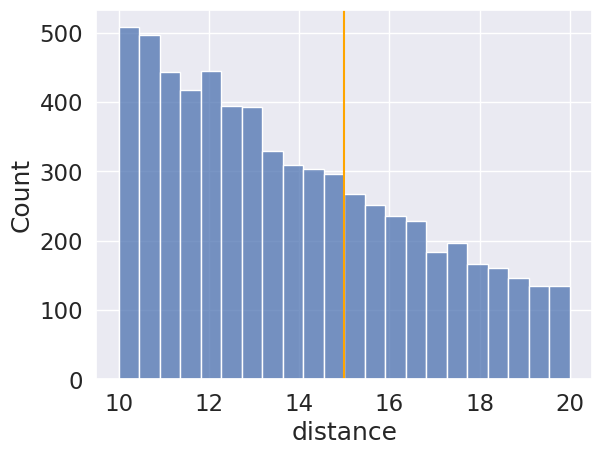

In [26]:
sns.histplot(df_rdd['distance'])
plt.axvline(x = 15, color = 'orange', linestyle = '-')

## D. Graph the Regression Discontinuity

Graph the data using the rdplot function from the rdrobust package. Remember to create a distance variable that is centered at 0 or specify the c argument in the rdplot function.

In [ ]:
# TODO: graph regression discontinuity data
# rdplot(y=, x=, c=)

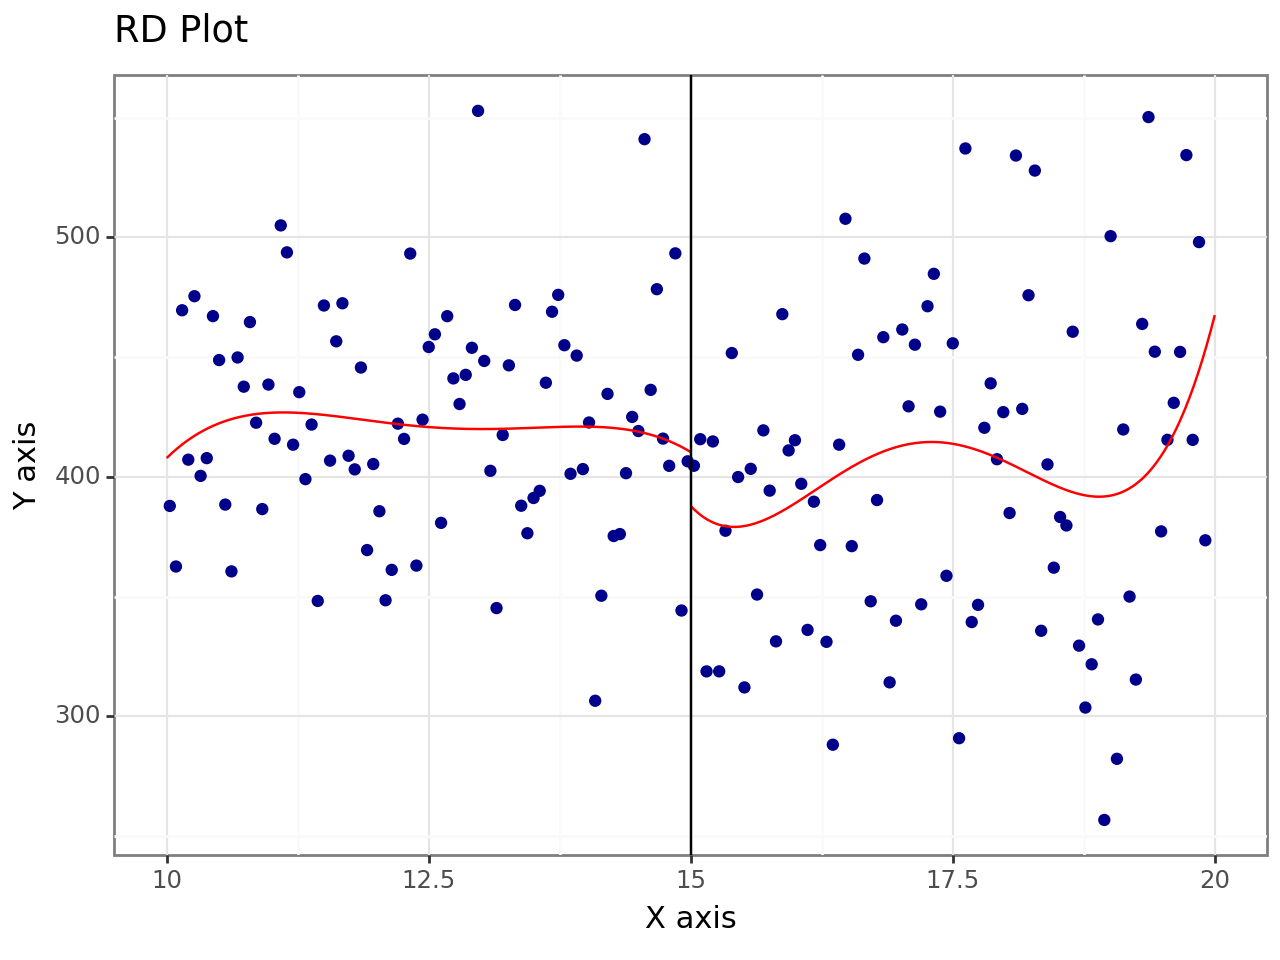


Call: rdplot
Number of Observations:                  6440
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          4336       2104
Number of Effective Obs         4336       2104
Bandwith poly. fit (h)         4.999      4.999
Number of bins scale               1          1
Bins Selected                     85         83
Average Bin Length             0.059       0.06
Median Bin Length              0.059       0.06
IMSE-optimal bins                4.0        5.0
Mimicking Variance bins         85.0       83.0

Relative to IMSE-optimal:
Implied scale                  21.25       16.6
WIMSE variance weight            0.0        0.0
WIMSE bias weight                1.0        1.0


In [27]:
rdplot(y=df_rdd['amount'], x=df_rdd['distance'], c=15)

## E. Fit RDD Models for Causal Effects

Now let's fit some regression discontinuity models with and without controls to estimate our causal effect of interest.

Remember because this is a fuzzy design we need to use two stage least squares due to the imperfect compliance with treatment. We can either do that using IV regression or with the fuzzy option in the rdrobust function. In Python it seems that the IV regression route is more stable and has lower variance compared to the rdrobust function, so we suggest using IV2SLS instead.

What do you conclude from your regression discontinuity analysis? How confident are you in the impact of in store shopping on customer value?

In [ ]:
# Using IV2SLS
# df_rdd_iv = df_rdd
# df_rdd_iv['intercept'] = 1
# NOTE: IV2SLS requires numerical variables so convert boolean to 0/1 indicator
# df_rdd_iv['treatment'] = 1 * df_rdd_iv['is_within_15_miles']

# TODO: fit model without controls
# model1 = IV2SLS().fit()

# TODO: fit model with controls
# model2 = IV2SLS().fit()

# Using rdrobust
# rdrobust(y=, x=, c=, fuzzy=, covs=)

In [37]:
# Using IV2SLS
df_rdd_iv = df_rdd
df_rdd_iv['intercept'] = 1
# NOTE: IV2SLS requires numerical variables so convert boolean to 0/1 indicator
df_rdd_iv['discontinuity_threshold'] = 1 * df_rdd_iv['is_within_15_miles']

# TODO: fit model without controls
model1_rdd = IV2SLS(
    df_rdd_iv[['amount']],
    df_rdd_iv[['intercept', 'in_store']],
    df_rdd_iv[['intercept', 'discontinuity_threshold']],
).fit()

# TODO: fit model with controls
model2_rdd = IV2SLS(
    df_rdd_iv[['amount']],
    df_rdd_iv[['intercept', 'age', 'distance', 'income', 'prior_amount', 'prior_in_store', 'is_credit', 'in_store']],
    df_rdd_iv[['intercept', 'age', 'distance', 'income', 'prior_amount', 'prior_in_store', 'is_credit', 'discontinuity_threshold']],
).fit()

# Using rdrobust
# rdrobust(y=, x=, c=, fuzzy=, covs=)

stargazer = Stargazer([model1_rdd, model2_rdd])
stargazer.covariate_order(['in_store'])
stargazer.custom_columns(['IV', 'IV + Controls'], [1, 1])
stargazer

In [ ]:
# TODO: display final results
# stargazer = Stargazer([model1, model2])
# stargazer.covariate_order(['in_store'])
# stargazer.custom_columns(['IV', 'IV + Controls'], [1, 1])
# stargazer

# If you define the treatment as has an in store transaction, your estimated causal effect should be around 85 for IV2SLS and 185 if you use rdrobust (with a large standard error)
# If you define the treatment as count of in store transactions, your estimated causal effect should be around 13 for IV2SLS and 23 if you use rdrobust (with a large standard error)
# If you define the treatment as percent of transactions in store, your estimated causal effect should be around 56 for IV2SLS and 109 if you use rdrobust (with a large standard error)

In [43]:
rdd_impact_mean = model2_rdd.params['in_store']
rdd_impact_value = model2_rdd.conf_int().loc['in_store']
rdd_impact_lwr = rdd_impact_value.loc[0]
rdd_impact_upr = rdd_impact_value.loc[1]

## IV. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so the VP of In Store Sales can follow along.

Again this step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested high level steps, but feel free to tweak as you see fit:
- Consider which of your approaches you consider to be the strongest evidence? Why?
- For that "main" modeling approach, share the results by putting them in **business terms** (e.g., "getting an online customer to shop in store boosts the value of a customer by X; if we can convince 100 online customers to shop in person, we can expect between Y and Z in additional revenue")
- Show key visuals to help someone grok the relationships intuitively
- Comment on our degree of confidence in the main approach and whether alternative approaches confirm those results and whether they are talking about different populations
- Contrast these results with the analysis you presented last week and why it is more or less rigorous in its findings
- Suggest concrete next steps / further next steps you would do based on these results

A good visual is to put the various model results into a table. Fill out the one below based on your analysis.

In [44]:
# Fill in with your IV results
iv_impact_mean = iv_impact_mean
iv_impact_lwr = iv_impact_lwr
iv_impact_upr = iv_impact_upr


# Fill in with your RDD results
rdd_impact_mean = rdd_impact_mean
rdd_impact_lwr = rdd_impact_lwr
rdd_impact_upr = rdd_impact_upr


summary_table = [
    ['Model Approach / Target Pop', 'Avg Revenue Impact', 'Lower Revenue Impact', 'Higher Revenue Impact'],
    ['IV Results: Impact on those we can nudge to shop in store with email', iv_impact_mean, iv_impact_lwr, iv_impact_upr],
    ['RDD Results: Impact on those who live close to store and can nudge to shop in store', rdd_impact_mean, rdd_impact_lwr, rdd_impact_upr]
]

print(tabulate(summary_table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════════════════════════════════════════════════════════════════╤══════════════════════╤════════════════════════╤═════════════════════════╕
│ Model Approach / Target Pop                                                         │   Avg Revenue Impact │   Lower Revenue Impact │   Higher Revenue Impact │
╞═════════════════════════════════════════════════════════════════════════════════════╪══════════════════════╪════════════════════════╪═════════════════════════╡
│ IV Results: Impact on those we can nudge to shop in store with email                │              28.3655 │                15.8212 │                 40.9097 │
├─────────────────────────────────────────────────────────────────────────────────────┼──────────────────────┼────────────────────────┼─────────────────────────┤
│ RDD Results: Impact on those who live close to store and can nudge to shop in store │              81.2958 │               -27.6212 │                190.213  │
╘═══════════════════════════

In [50]:
%%markdown
# Executive summary
Getting an online customer to shop in store boosts the value of a customer by 28 dollars; if we can convince 100 online customers to shop in person, we can expect between 15k dollars and 41k dollars in additional revenue.
Instrumental variable seems to be a more robust model to use here because an email with a free gift looks like a more likely move to nudge customers to purchase in store compared to just distance to the shop. In second RDD model we didn't see a clear impact on revenue because our range impact on LTV is between -27 to 190 dollars.
## Next steps:
We should target more user with email to visit store but we cannot offer free gift to all customers who turn up in store thus we should find incentive that's work but is still financially viable.

# Executive summary
Getting an online customer to shop in store boosts the value of a customer by 28 dollars; if we can convince 100 online customers to shop in person, we can expect between 15k dollars and 41k dollars in additional revenue.
Instrumental variable seems to be a more robust model to use here because an email with a free gift looks like a more likely move to nudge customers to purchase in store compared to just distance to the shop. In second RDD model we didn't see a clear impact on revenue because our range impact on LTV is between -27 to 190 dollars.   
## Next steps:  
We should target more user with email to visit store but we cannot offer free gift to all customers who turn up in store thus we should find incentive that's work but is still financially viable.


Another good thing to do is translate the per customer impact above to overall customer impact.

We could, for example, say in our data set we have `3609` unique customers and with a compliance rate of `63.97%`, so we can drive N * X% * $IV = `$65,486.7` Impact Value of total revenue by getting customers to shop in store through a marketing email campaign.

This can be weighed against other alternatives and discussed in terms of the strategic value.

Calculate this using the results of your analysis.

In [68]:
#  calculate number of customers who don't shop onlide
df_grouped = df.groupby('customer_id').agg({
    'in_store': 'mean'
})
n_customers_shopping_only_online = df_grouped[df_grouped['in_store'] == 0].count()
n_customers_shopping_only_online

in_store    3609
dtype: int64

In [66]:
n_customers = n_customers_shopping_only_online # Number of customers not shopping online <-- should this be number of customer who only shops online???
compliance_rate = 0.6397 # Compliance rate for marketing email nudging people to shop online
iv_impact_mean = iv_impact_mean #Marginal impact of nudging customer to shop online

total_value = n_customers * compliance_rate * iv_impact_mean # Total opportunity estimate for in store shopping
print('$' + str(round(total_value, 2)))

$in_store    65486.7
dtype: float64
